# Playing with I
----

Let's say we have a function with two parameters $a$ and $b$
\begin{align}
f_{a,b}(t) = a\cdot b \cdot t^2
\end{align}

We want to get the values of the coefficients $a$ and $b$ such that $f$ corresponds to "experimental data"

For the sake of this example, those "experimental data" will be generated using $a=2$ and $b=2$
This is an ill-posed problem as it is equivalent to solve:
\begin{align}
a\cdot b \cdot t^2 = 4\cdot t^2,
\end{align}
which has an infinite number of solutions

Consequently if we try to plot the cost function of the problem, *eg* for instance:
\begin{align}
\Psi(a,b) = \sqrt{\frac{1}{T}\sum_{t=0}^T (f_{a,b}(t) -f_{2,2}(t))^2},
\end{align}
we get the following:

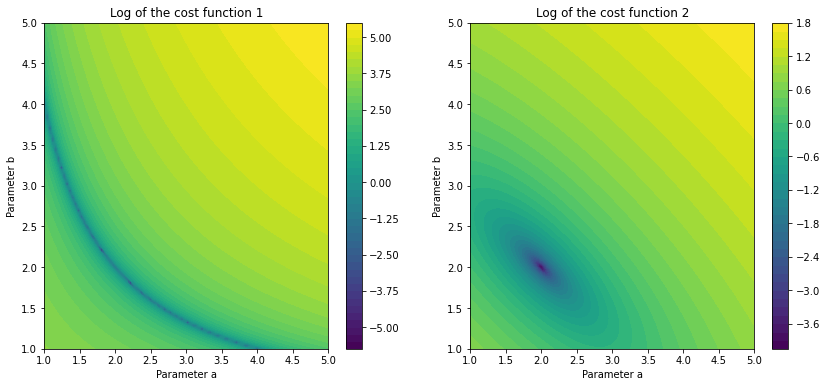

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def test_fun(a, b, x, costNum):
    '''Basic test function with two parameters a and b'''
    if costNum==1:
        return a * b * x**2
    else:
        return a + (b/10) * x**2

def plot_costFun(costNum):
    a=2
    b=2
    T = 100
    t = np.linspace(0,5,T)
    U = test_fun(a, b, t, costNum)
    a_grid = np.linspace(1.,5.,100)
    b_grid = np.linspace(1.,5.,100)
    A, B = np.meshgrid(a_grid, b_grid)
    costFun = np.zeros((100, 100))
    for i in range(0, 100):
        for j in range(0, 100):
            funVal = test_fun(A[i,j], B[i,j], t, costNum)
            costFun[i, j] = math.sqrt(np.sum((funVal - U)**2)/T)
    
    plt.contourf(A, B, np.log(costFun), 50)
    plt.xlabel("Parameter a")
    plt.ylabel("Parameter b")
    plt.title("Log of the cost function "+str(costNum))
    plt.colorbar()
    
plt.figure(figsize=(14,6))
plt.subplot(121)
plot_costFun(1)
plt.subplot(122)
plot_costFun(2)
plt.show()
plt.close()

As you can see, the infinite possibility of solution is visible on the cost function plot 1, whereas the second cost function is a better posed problem as the solution is more unique and the two parameters have similar influence strengths.

When the function to optimize takes time to compute (for instance, for inverse identification using Finite Element analyses), it can be tedious to plot the whole cost function to characterize the problem well-posedness.

Alternatively, one can compute indicators of the convexity of the cost-function close to the solution, such as the following:

\begin{align}
I = \log_{10} \left(\frac{\lambda_{max}}{\lambda_{min}}\right),
\end{align}

where $\lambda_{min}$ and $\lambda_{max}$ are the eigen values of the cost function hessian matrix close to the solution, which can be approximated as:

\begin{equation}
  	\overline{H}_{ij} = \sum_{t=0}^T \frac{\partial \overline{f}(t)}{\partial \overline{p_i}} \frac{\partial \overline{f}(t)}{\partial \overline{p_j}},
\end{equation}

where, p is the parameter vector, which is in our case $p = \{a, b\}$

In the case of two parameters and for an ellipsoid cost function, $I$ can be seen as the ratio of the two principal axes of the ellipse close to the minimum.

Therefore, a high value of $I$ implies that the cost function is more stretched toward a given axis which means that the problem is ill-posed as several solutions become possible.

On the contrary, $I=0$ means that the cost function minima is a single point.

## What about noisy data ?
----

$I$ mainly measures two things:
- Is the function sensitive to a variation of the different parameters with a similar strength ?
- Do the parameters have different influences on the function ?

If two parameters have a similar influence on the cost function (*eg* their sensitivity vectors are collinear), it can be difficult to decorelate their effect on the function. Put differently, it would be difficult to identify those two parameters at the same time.

Let's take the function $f$ defined above. If we change the value of $a$ or $b$ by 5\% successively, the effect on $f$ will be the same. Those two parameters are therefore highly correlated which is another way to understand why the problem is ill-posed.

In the following code, let's compute the sensitivity of $f$ to a variation of $a$ and $b$ by $\epsilon$, defined as:
\begin{equation}
\frac{\partial f}{\partial p_i}(t) = \frac{1}{\epsilon \sqrt{T} max_t(f)} \left(f_{1.05*p_i}(t) - f_{2,2}(t)\right)
\end{equation}

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def noise(b,t):
    '''Sinusoidal noise of amplitude b and frequency w'''
    return np.random.normal(0,b,len(t))
    
def comp_I_bin(dXdT):
    '''Computes the identifiability indicator from a given sensitivity matrix'''
    numVars = dXdT.shape[0]
    H = np.zeros((numVars, numVars))
    T = dXdT.shape[1]
    for i in range(0,numVars):
        for j in range(0,numVars):
            H[i,j] = np.nansum(dXdT[i]*dXdT[j])

    lams = np.linalg.eigvals(H)
    I = np.log10(np.max(lams)/np.min(lams))
    return I


def comp_sensi_vector(noise_amp=0.):
    a = 2.
    b = 2.  
    T = 100
    eps = 0.05
    t = np.linspace(0,5,T)
    U = test_fun(a, b, t, 1) + noise(noise_amp, t)
    U_5pc = test_fun((1.+eps)*a, b, t, 1) + noise(noise_amp, t)
    U_5pc_noise = test_fun(a, (1.+eps) * b, t, 1) + noise(noise_amp, t)

    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title("Function f")
    plt.plot(t, U, label="$f_{a,b}(t)$")
    plt.plot(t, U_5pc, label="$f_{1.05*a,b}(t)$")
    plt.plot(t, U_5pc_noise, label="$f_{a,1.05*b}(t)$")
    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()

    plt.subplot(122)
    plt.title("Sensitivity variation")
    dSdX = np.zeros((2,T))
    dSdX[0,:] = (U_5pc - U)/(eps * math.sqrt(T) * np.max(U))
    dSdX[1,:] = (U_5pc_noise - U)/(eps * math.sqrt(T) * np.max(U))
    plt.plot(t, dSdX[0], label="$f_{1.05*a,b}(t)$")
    plt.plot(t, dSdX[1], label="$f_{a,1.05*b}(t)$")
    plt.xlabel("t")
    plt.ylabel("$df/d\\theta$")
    plt.legend()
    plt.show()
    plt.close()
    
    I = comp_I_bin(dSdX)
    print("Value of I: {:.02f}".format(I))

 
print("Noise amplitude")
interact(comp_sensi_vector, noise_amp=(0.,0.5,0.01))


Noise amplitude


interactive(children=(FloatSlider(value=0.0, description='noise_amp', max=0.5, step=0.01), Output()), _dom_cla…

<function __main__.comp_sensi_vector(noise_amp=0.0)>

The graph on the left shows the variation of $f$ with $t$ for the reference state $\{a=2, b=2\}$ and after a pertubation of $a$ and $b$ by $5\%$. The graph on the right shows the sensitivity of $f$ to the two coefficients computed accordingly. It illustrates well the high correlation of $a$ and $b$ as the sensitivity curves are the same. Accordingly, it results in a very bad value of $I$ shown below the graphs (16.17)

When moving the slider, a random gaussian noise is added to the three curves. Indeed, in real life applications, simulated curves can be noisy due to interpolation errors, numerical uncertainties, etc...

When increasing the noise level, you can see that the sensitivity becomes even noisier (as it is a derivative of the initial signal). Consequently, the two sentivity curves become artificially decorrelated as the noise is random which results in a better value of $I$.

However this better value is only artificial as it does not result on the effect of $a$ and $b$ being different !

The influence of noise on the value of $I$ should therefore be carefully investigated and its absolute value not just taken for granted.